# Clairvoyant Clustering of Consumer Complaints
- analyzed consumer complaints filed to the Consumer Financial Protection Bureau  (CFPB)
- data downloaded from CFPB's [Consumer Complaint Database](https://www.consumerfinance.gov/data-research/consumer-complaints/search/?dataLens=Overview&dataNormalization=None&dateInterval=Month&dateRange=3y&date_received_max=2020-06-21&date_received_min=2017-06-21&from=0&page=1&searchField=all&size=25&sort=created_date_desc&tab=Map)
- data filters:  Debt Collection product category filed between June 1, 2019 - May 31, 2020
- NLP tools: SpaCy and CorEx (notebook #2)  
- unsupervised machine learning: K-Means clustering (notebook #3) and Principal Component Analysis (notebook #4)

In [1]:
# Make better use of Jupyter Notebook cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import re
import pickle

import spacy
from collections import Counter
from spacy.symbols import amod
from pprint import pprint
import string

from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

## Functions

In [3]:
def load_data(csv_file):
    '''
    Load data from a CSV file.
    One of the columns must be called 'Date received' with dtype: object that can be converted to a datetime dtype.
    '''
    df_orig = pd.read_csv(csv_file, delimiter=",")
    df_orig.loc[:, 'Date received'] = pd.to_datetime(df_orig['Date received'])
    print(df_orig.info())
    return df_orig

In [4]:
def complaints_summary_per_company(original_dataframe):
    '''
    Use original dataframe to create new dataframe to look at number of complaints per Company, 
        sorted by highest number of complaints.
        
    One of the columns must be called 'Company'.
    
    Add columns 'cum_sum' and 'cum_perc' to see cumulative number and percentage of complaints 
        (based on sort ordered by highest # of complaints).
    '''
    df_complaint_num = pd.DataFrame(original_dataframe['Company'].value_counts())
    df_complaint_num.rename(columns={'Company':'num_complaints'}, inplace=True)
    df_complaint_num['cum_sum'] = df_complaint_num['num_complaints'].cumsum()
    df_complaint_num['cum_perc'] = round(100*df_complaint_num['cum_sum'] / df_complaint_num['num_complaints'].sum(),2)
    return df_complaint_num

In [5]:
def top_companies_bar_chart(original_dataframe):
    '''
    Use original dataframe to create a bar chart to see top 100 companies and number of complaints each one has.
    '''
    company = original_dataframe['Company'].value_counts()[:99].plot(kind='bar', figsize=(20,8), 
                                                          title='Number of Debt Collection Complaints for each Company')
    company.set_xlabel('Company')
    company.set_ylabel('# of Complaints')
    return company

In [6]:
def initial_split(complaints_summary_df, original_dataframe, complaint_threshold=10):
    '''
    Split dataframe with summary of complaints, 'complaints_summary_df', roughly along 80/20 rule to generate a list 
        with names of the 20% of companies that generate 80% of complaints. 
        
    Use this list to filter 'original_dataframe'.
    
    Return new dataframe that is a subset of 'original_dataframe', i.e., with entries for the top ~80% of complaints.
        
    'complaints_summary_df' dataframe must include column named 'num_complaints'.
    
    'original_dataframe' must include column named 'Company'.
    
    'complaint_threshold' represents minimum total number of complaints a company must have for its complaints 
        to be included in the top ~80% of complaints.

    '''
    # create dataframe of companies with 10 or more complaints
    top_80_perc_complaints = complaints_summary_df[complaints_summary_df['num_complaints'] >= complaint_threshold]
    top_80_perc_complaints = top_80_perc_complaints.rename_axis('Company').reset_index()
    
    # create LIST of companies that have 10 or more complaints
    top_80_perc_complaints_list = top_80_perc_complaints['Company'].to_list()
    
    # filter 'original_dataframe' by 'top_80_perc_complaints_list'
    initial_split_dataframe = original_dataframe[original_dataframe['Company'].isin(top_80_perc_complaints_list)]
    initial_split_dataframe = initial_split_dataframe.rename_axis('orig_index').reset_index()
    
    return initial_split_dataframe

In [7]:
def clean_text(text):
    '''
    Light cleaning to remove \n, XXXX and words containing numbers from the complaint narratives
    ''' 
    text = re.sub('\n', '', text)
    text = re.sub('XX/', '', text)
    text = re.sub('XXXX', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [8]:
def get_amods(noun, ser):
    '''
    For a given noun of interest, extract each of the adjectival modifiers that are among its children tokens.
    '''
    amod_list = []
    for doc in ser:
        for token in doc:
            if (token.text) == noun:
                for child in token.children:
                    if child.dep == amod:
                        amod_list.append(child.text.lower())
    return Counter(amod_list)

def amods_of_nouns(noun):
    print(f"Adjectives describing {str.upper(noun)}:\n")
    
    pprint(get_amods(noun, df_spacy_debt['spacy_doc']))

In [9]:
stopwords = stopwords.words('english')
punctuations = string.punctuation

def clean_spacy_doc(doc, tags=['NOUN', 'ADJ']):
    '''
    Lemmatize tokenized narratives;
    Use SpaCy POS tags to filter for nouns and adjectives;
    Remove stopwords (NLTK) and punctuations;
    Returns string of filtered text.
    '''
    cleaned_doc = []
    tokens = [tok.lemma_.lower() for tok in doc if tok.pos_ in tags]
    tokens = [tok for tok in tokens if tok not in stopwords and tok not in punctuations]
    tokens = ' '.join(tokens)
    cleaned_doc.append(tokens)
    return pd.Series(cleaned_doc)

In [10]:
def clean_spacy_doc2(doc):
    '''
    Use SpaCy to remove stopwords;
    Lemmatize tokenized narratives;
    Remove punctuations;
    Returns string of filtered text.
    '''
    cleaned_doc = []
    tokens = [tok for tok in doc if tok.is_stop == False] 
    tokens = [tok.lemma_.lower() for tok in tokens]
    tokens = [tok for tok in tokens if tok not in punctuations]
    tokens = ' '.join(tokens)
    cleaned_doc.append(tokens)
    return pd.Series(cleaned_doc)

## Load data

In [11]:
# call load_data function
df_orig = load_data('cfpb_debt_coll_20190601_to_20200531.csv')
df_orig

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21831 entries, 0 to 21830
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Date received                 21831 non-null  datetime64[ns]
 1   Product                       21831 non-null  object        
 2   Sub-product                   21831 non-null  object        
 3   Issue                         21831 non-null  object        
 4   Sub-issue                     21831 non-null  object        
 5   Consumer complaint narrative  21831 non-null  object        
 6   Company public response       21831 non-null  object        
 7   Company                       21831 non-null  object        
 8   State                         21831 non-null  object        
 9   ZIP code                      21831 non-null  object        
 10  Tags                          21831 non-null  object        
 11  Consumer consent provided?  

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2020-05-07,Debt collection,Other debt,Attempts to collect debt not owed,Debt is not yours,I received an alert from XXXX XXXX on XX/XX/XX...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",LA,700XX,None,Consent provided,Web,05/07/20,Closed with explanation,Yes,NaN,3642003
1,2019-12-13,Debt collection,Other debt,Attempts to collect debt not owed,Debt was result of identity theft,This kind of account is placed as a charged of...,Company believes the complaint is the result o...,"Commercial Trade, Inc.",CA,933XX,None,Consent provided,Web,12/16/19,Closed with explanation,Yes,NaN,3467207
2,2020-02-11,Debt collection,Other debt,Took or threatened to take negative or legal a...,Seized or attempted to seize your property,See uploaded document dated XXXX ; CHASE BANK ...,None,JPMORGAN CHASE & CO.,GA,301XX,None,Consent provided,Web,02/11/20,Closed with explanation,Yes,NaN,3527527
3,2020-05-27,Debt collection,Other debt,Written notification about debt,Didn't receive enough information to verify debt,On XX/XX/XXXX I pulled my credit report and sa...,Company believes it acted appropriately as aut...,Monterey Financial Services LLC,NY,None,None,Consent provided,Web,05/27/20,Closed with explanation,Yes,NaN,3670227
4,2020-01-11,Debt collection,Other debt,Written notification about debt,Didn't receive notice of right to dispute,My XXXX ( XXXX ) Account number for Internet s...,None,AFNI INC.,FL,320XX,None,Consent provided,Web,01/11/20,Closed with explanation,Yes,NaN,3492864
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21826,2020-05-24,Debt collection,Credit card debt,Attempts to collect debt not owed,Debt was result of identity theft,THIS IS A COMPLAINT AGAINST STATE FARM BANK. F...,Company has responded to the consumer and the ...,"STATE FARM BANK, FSB",FL,330XX,None,Consent provided,Web,05/24/20,Closed with explanation,Yes,NaN,3666638
21827,2020-05-03,Debt collection,Credit card debt,Attempts to collect debt not owed,Debt was paid,using Lowe 's Advantage card I made online fro...,Company has responded to the consumer and the ...,SYNCHRONY FINANCIAL,WA,981XX,None,Consent provided,Web,05/03/20,Closed with monetary relief,Yes,NaN,3635213
21828,2020-04-05,Debt collection,Credit card debt,Took or threatened to take negative or legal a...,Threatened or suggested your credit would be d...,In XX/XX/XXXX I paid the full amount of my XXX...,None,Alliance Data Card Services,TX,None,None,Consent provided,Web,04/05/20,Closed with non-monetary relief,Yes,NaN,3593729
21829,2020-03-28,Debt collection,Credit card debt,Took or threatened to take negative or legal a...,Threatened to sue you for very old debt,XX/XX/XXXX my sister called to inform me that ...,Company has responded to the consumer and the ...,WELLS FARGO & COMPANY,CA,934XX,None,Consent provided,Web,04/01/20,Closed with explanation,Yes,NaN,3584339


In [12]:
df_orig['Issue'].value_counts()
# 6 issues within Debt Collection product

Attempts to collect debt not owed                                10217
Written notification about debt                                   3889
Took or threatened to take negative or legal action               2392
False statements or representation                                2374
Communication tactics                                             2348
Threatened to contact someone or share information improperly      611
Name: Issue, dtype: int64

## How many companies are named in these credit reporting complaints?
## How many complaints does each company have?

In [13]:
# call complaints_summary_per_company function
# 1655 companies
df_complaint_num = complaints_summary_per_company(df_orig)
df_complaint_num

,num_complaints,cum_sum,cum_perc
PORTFOLIO RECOVERY ASSOCIATES INC,900,900,4.12
ENCORE CAPITAL GROUP INC.,694,1594,7.30
Resurgent Capital Services L.P.,512,2106,9.65
CAPITAL ONE FINANCIAL CORPORATION,473,2579,11.81
ERC,418,2997,13.73
...,...,...,...
Integrated Mediation Solutions LLC,1,21827,99.98
"Harmon Law Offices, P.C.",1,21828,99.99
"Modlin Slinsky, P.A.",1,21829,99.99
"BERKSHIRE HILLS BANCORP, INC",1,21830,100.00


In [14]:
# at around 83%, companies have fewer than 10 complaints
df_complaint_num[df_complaint_num['cum_perc'] >= 83]

,num_complaints,cum_sum,cum_perc
"Financial Recovery Services, Inc.",10,18126,83.03
"Retrieval-Masters Creditors Bureau, Inc.",10,18136,83.07
"SUNTRUST BANKS, INC.",10,18146,83.12
"Glasser and Glasser, PLC",10,18156,83.17
"FLAGSTAR BANK, FSB",9,18165,83.21
...,...,...,...
Integrated Mediation Solutions LLC,1,21827,99.98
"Harmon Law Offices, P.C.",1,21828,99.99
"Modlin Slinsky, P.A.",1,21829,99.99
"BERKSHIRE HILLS BANCORP, INC",1,21830,100.00


In [15]:
# total num companies - number of companies after ~83% cutoff = 333 companies
1655-1322

333

In [16]:
# 333 companies = 20% of all companies make up ~83% of complaints 
# use for initial split
333/1655

0.2012084592145015

In [37]:
# pickle df_complaint_num
# df_complaint_num.to_pickle('df_complaint_num.pkl')

## Bar chart to see top 100 companies & number of complaints 
- big drop off after first 2 companies

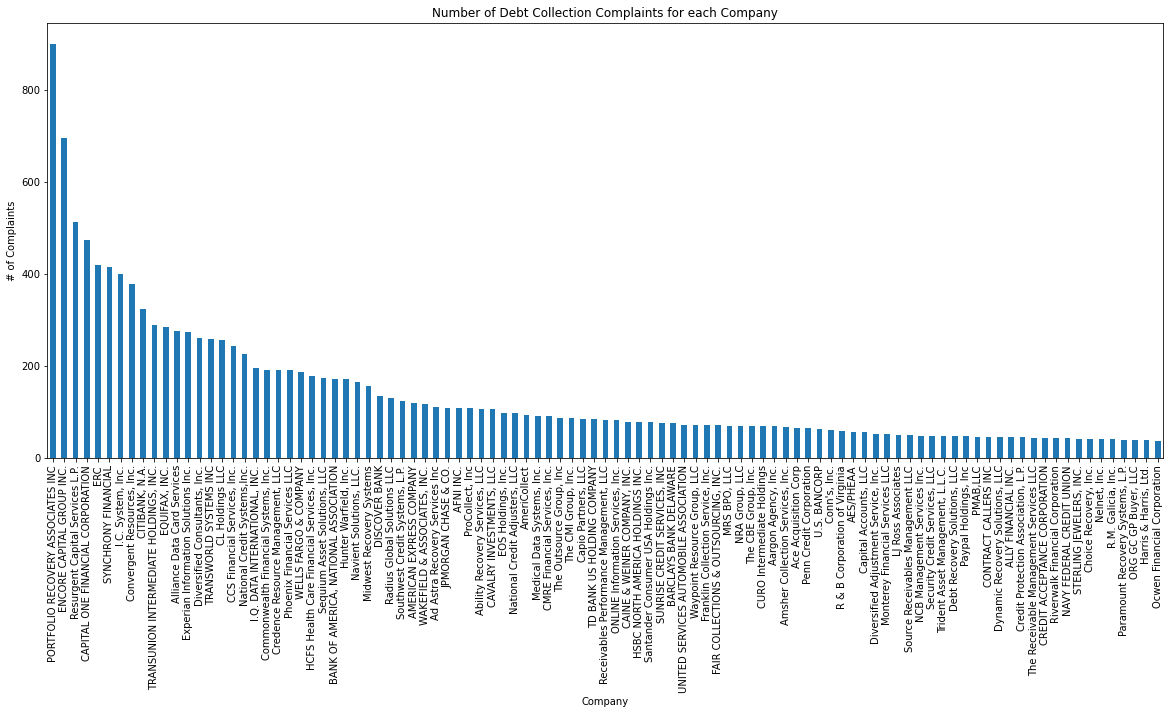

In [17]:
# call top_companies_bar_chart function
top_companies_bar_chart(df_orig);

## Initial split!
- to focus on the ~80% of complaints generated by ~20% of companies
- means removing companies that have fewer than 10 complaints

In [18]:
# call initial_split function
df_split = initial_split(df_complaint_num, df_orig)
df_split

,orig_index,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,0,2020-05-07,Debt collection,Other debt,Attempts to collect debt not owed,Debt is not yours,I received an alert from XXXX XXXX on XX/XX/XX...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",LA,700XX,None,Consent provided,Web,05/07/20,Closed with explanation,Yes,NaN,3642003
1,2,2020-02-11,Debt collection,Other debt,Took or threatened to take negative or legal a...,Seized or attempted to seize your property,See uploaded document dated XXXX ; CHASE BANK ...,None,JPMORGAN CHASE & CO.,GA,301XX,None,Consent provided,Web,02/11/20,Closed with explanation,Yes,NaN,3527527
2,3,2020-05-27,Debt collection,Other debt,Written notification about debt,Didn't receive enough information to verify debt,On XX/XX/XXXX I pulled my credit report and sa...,Company believes it acted appropriately as aut...,Monterey Financial Services LLC,NY,None,None,Consent provided,Web,05/27/20,Closed with explanation,Yes,NaN,3670227
3,4,2020-01-11,Debt collection,Other debt,Written notification about debt,Didn't receive notice of right to dispute,My XXXX ( XXXX ) Account number for Internet s...,None,AFNI INC.,FL,320XX,None,Consent provided,Web,01/11/20,Closed with explanation,Yes,NaN,3492864
4,5,2020-01-22,Debt collection,Medical debt,Took or threatened to take negative or legal a...,Threatened or suggested your credit would be d...,AMCOL Systems ( a debt collector ) reported a ...,None,"AMCOL Systems, Inc.",TX,775XX,None,Consent provided,Web,01/22/20,Closed with explanation,Yes,NaN,3504908
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18151,21825,2020-05-23,Debt collection,Other debt,Attempts to collect debt not owed,Debt is not yours,"I was made aware, that once again, XXXX XXXX c...",Company has responded to the consumer and the ...,The Receivable Management Services LLC,WV,258XX,None,Consent provided,Web,05/23/20,Closed with explanation,Yes,NaN,3666313
18152,21827,2020-05-03,Debt collection,Credit card debt,Attempts to collect debt not owed,Debt was paid,using Lowe 's Advantage card I made online fro...,Company has responded to the consumer and the ...,SYNCHRONY FINANCIAL,WA,981XX,None,Consent provided,Web,05/03/20,Closed with monetary relief,Yes,NaN,3635213
18153,21828,2020-04-05,Debt collection,Credit card debt,Took or threatened to take negative or legal a...,Threatened or suggested your credit would be d...,In XX/XX/XXXX I paid the full amount of my XXX...,None,Alliance Data Card Services,TX,None,None,Consent provided,Web,04/05/20,Closed with non-monetary relief,Yes,NaN,3593729
18154,21829,2020-03-28,Debt collection,Credit card debt,Took or threatened to take negative or legal a...,Threatened to sue you for very old debt,XX/XX/XXXX my sister called to inform me that ...,Company has responded to the consumer and the ...,WELLS FARGO & COMPANY,CA,934XX,None,Consent provided,Web,04/01/20,Closed with explanation,Yes,NaN,3584339


In [19]:
# check number of companies in df_split
# 337 is the right number!
df_split['Company'].value_counts()

PORTFOLIO RECOVERY ASSOCIATES INC           900
ENCORE CAPITAL GROUP INC.                   694
Resurgent Capital Services L.P.             512
CAPITAL ONE FINANCIAL CORPORATION           473
ERC                                         418
                                           ... 
Glasser and Glasser, PLC                     10
FISERV INC.                                  10
Financial Recovery Services, Inc.            10
Credit Bureau Systems, Inc.                  10
Retrieval-Masters Creditors Bureau, Inc.     10
Name: Company, Length: 337, dtype: int64

In [ ]:
# pickle df_split
df_split.to_pickle('df_split_clean.pkl')

## Pre-process the data
- light cleaning
- use SpaCy for tokenization, lemmatization, part-of-speech tagging, dependency parsing

In [20]:
# call clean_text function and create new column in dataframe with cleaned narratives
df_split['cleaned_narrative'] = df_split['Consumer complaint narrative'].apply(clean_text)
df_split.head(10)

,orig_index,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID,cleaned_narrative
0,0,2020-05-07,Debt collection,Other debt,Attempts to collect debt not owed,Debt is not yours,I received an alert from XXXX XXXX on XX/XX/XX...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",LA,700XX,None,Consent provided,Web,05/07/20,Closed with explanation,Yes,NaN,3642003,I received an alert from on about a Collect...
1,2,2020-02-11,Debt collection,Other debt,Took or threatened to take negative or legal a...,Seized or attempted to seize your property,See uploaded document dated XXXX ; CHASE BANK ...,None,JPMORGAN CHASE & CO.,GA,301XX,None,Consent provided,Web,02/11/20,Closed with explanation,Yes,NaN,3527527,See uploaded document dated ; CHASE BANK unla...
2,3,2020-05-27,Debt collection,Other debt,Written notification about debt,Didn't receive enough information to verify debt,On XX/XX/XXXX I pulled my credit report and sa...,Company believes it acted appropriately as aut...,Monterey Financial Services LLC,NY,None,None,Consent provided,Web,05/27/20,Closed with explanation,Yes,NaN,3670227,On I pulled my credit report and saw Monterey...
3,4,2020-01-11,Debt collection,Other debt,Written notification about debt,Didn't receive notice of right to dispute,My XXXX ( XXXX ) Account number for Internet s...,None,AFNI INC.,FL,320XX,None,Consent provided,Web,01/11/20,Closed with explanation,Yes,NaN,3492864,My ( ) Account number for Internet services ...
4,5,2020-01-22,Debt collection,Medical debt,Took or threatened to take negative or legal a...,Threatened or suggested your credit would be d...,AMCOL Systems ( a debt collector ) reported a ...,None,"AMCOL Systems, Inc.",TX,775XX,None,Consent provided,Web,01/22/20,Closed with explanation,Yes,NaN,3504908,AMCOL Systems ( a debt collector ) reported a ...
5,6,2020-04-16,Debt collection,Credit card debt,Attempts to collect debt not owed,Debt was already discharged in bankruptcy and ...,XXXX XXXX is reporting to Transunion a debt so...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",CO,805XX,None,Consent provided,Web,04/17/20,Closed with explanation,Yes,NaN,3610138,is reporting to Transunion a debt sold to ...
6,7,2020-01-22,Debt collection,Other debt,Written notification about debt,Didn't receive enough information to verify debt,I was XXXX in XXXX from XX/XX/XXXX to XX/XX/XX...,None,"ONLINE Information Services, Inc.",KY,404XX,None,Consent provided,Web,01/22/20,Closed with non-monetary relief,Yes,NaN,3505172,"I was in from to . I called , explained m..."
7,8,2020-04-13,Debt collection,Other debt,Attempts to collect debt not owed,Debt was result of identity theft,I am receiving phone calls and letters in the ...,Company has responded to the consumer and the ...,"I.C. System, Inc.",OK,None,None,Consent provided,Web,04/13/20,Closed with explanation,Yes,NaN,3605084,I am receiving phone calls and letters in the ...
8,9,2019-12-30,Debt collection,Other debt,Attempts to collect debt not owed,Debt is not yours,"To Whom It May Concern, The reason for my disp...",Company has responded to the consumer and the ...,"HCFS Health Care Financial Services, Inc.",OH,432XX,None,Consent provided,Web,12/30/19,Closed with explanation,Yes,NaN,3480106,"To Whom It May Concern, The reason for my disp..."
9,10,2020-04-27,Debt collection,Other debt,Attempts to collect debt not owed,Debt is not yours,After reviewing my credit report on both XXXX ...,Company has responded to the consumer and the ...,"Convergent Resources, Inc.",NY,100XX,None,Consent provided,Web,04/27/20,Closed with explanation,Yes,NaN,3624387,After reviewing my credit report on both and ...


#### SpaCy pipeline

In [21]:
# disable SpaCy's name entity recognition (if we want company names, it's in the 'Company' column of original dataframe)
nlp = spacy.load('en_core_web_sm', disable='ner')

In [22]:
# run SpaCy pipeline on cleaned narratives; add as new column
# takes several minutes
df_split['spacy_doc'] = list(nlp.pipe(df_split['cleaned_narrative']))

In [23]:
df_split.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18156 entries, 0 to 18155
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   orig_index                    18156 non-null  int64         
 1   Date received                 18156 non-null  datetime64[ns]
 2   Product                       18156 non-null  object        
 3   Sub-product                   18156 non-null  object        
 4   Issue                         18156 non-null  object        
 5   Sub-issue                     18156 non-null  object        
 6   Consumer complaint narrative  18156 non-null  object        
 7   Company public response       18156 non-null  object        
 8   Company                       18156 non-null  object        
 9   State                         18156 non-null  object        
 10  ZIP code                      18156 non-null  object        
 11  Tags                        

In [24]:
# see SpaCy pre-processing results on a sample text
for token in df_split['spacy_doc'][51]:
    print(token, token.pos, token.lemma_, token.is_stop)

After 85 after True
reviewing 100 review False
my 95 -PRON- True
free 84 free False
credit 92 credit False
reports 92 report False
I 95 -PRON- True
noticed 100 notice False
a 90 a True
fraudulent 84 fraudulent False
account 92 account False
from 85 from True
Americollect 96 Americollect False
that 95 that True
does 87 do True
n't 94 not True
belong 100 belong False
to 85 to True
me 95 -PRON- True
and 89 and True
after 85 after True
contacting 100 contact False
them 95 -PRON- True
they 95 -PRON- True
still 86 still True
refuse 100 refuse False
to 94 to True
remove 100 remove False
from 85 from True
my 95 -PRON- True
credit 92 credit False
reports 92 report False
and 89 and True
send 100 send False
me 95 -PRON- True
verification 92 verification False
under 85 under True
the 90 the True
fair 84 fair False
credit 92 credit False
reporting 92 reporting False
act 92 act False
. 97 . False


In [25]:
# create smaller dataframe to work with
df_spacy_debt = df_split[['Company', 'cleaned_narrative','spacy_doc']]
df_spacy_debt.head()

,Company,cleaned_narrative,spacy_doc
0,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",I received an alert from on about a Collect...,"(I, received, an, alert, from, , on, , abou..."
1,JPMORGAN CHASE & CO.,See uploaded document dated ; CHASE BANK unla...,"(See, uploaded, document, dated, , ;, CHASE, ..."
2,Monterey Financial Services LLC,On I pulled my credit report and saw Monterey...,"(On, , I, pulled, my, credit, report, and, sa..."
3,AFNI INC.,My ( ) Account number for Internet services ...,"(My, , (, , ), Account, number, for, Interne..."
4,"AMCOL Systems, Inc.",AMCOL Systems ( a debt collector ) reported a ...,"(AMCOL, Systems, (, a, debt, collector, ), rep..."


## Look at most common words

In [26]:
adjectives = [token.text.lower() for doc in df_spacy_debt['spacy_doc'] for token in doc if token.pos_=='ADJ']
Counter(adjectives).most_common(15)

[('original', 4186),
 ('legal', 2973),
 ('other', 2898),
 ('same', 2356),
 ('last', 2153),
 ('several', 2105),
 ('full', 2076),
 ('such', 1929),
 ('medical', 1771),
 ('new', 1757),
 ('due', 1688),
 ('more', 1663),
 ('alleged', 1607),
 ('fraudulent', 1594),
 ('personal', 1512)]

In [27]:
nouns = [token.text.lower() for doc in df_spacy_debt['spacy_doc'] for token in doc if token.pos_=='NOUN']
Counter(nouns).most_common(15)

[('debt', 29303),
 ('credit', 22677),
 ('account', 20787),
 ('company', 12665),
 ('information', 10556),
 ('collection', 10317),
 ('report', 9150),
 ('letter', 7794),
 ('phone', 5972),
 ('amount', 5921),
 ('number', 5422),
 ('time', 5343),
 ('payment', 5333),
 ('name', 4319),
 ('agency', 4282)]

## Dependancy parsing
- explore the adjectives that describe some of the most common nouns

In [28]:
amods_of_nouns('debt')

Adjectives describing DEBT:

Counter({'alleged': 1379,
         'medical': 213,
         'same': 195,
         'original': 184,
         'old': 178,
         'outstanding': 110,
         'fraudulent': 70,
         'said': 70,
         'false': 70,
         'valid': 69,
         'past': 64,
         'disputed': 57,
         'supposed': 56,
         'new': 54,
         'invalid': 54,
         'such': 50,
         'unpaid': 49,
         'erroneous': 49,
         'bad': 49,
         'unverified': 28,
         'called': 27,
         'bogus': 26,
         'barred': 25,
         'due': 23,
         'referenced': 22,
         'entire': 22,
         'paid': 21,
         'cumulative': 20,
         'unknown': 20,
         'claimed': 19,
         'inaccurate': 18,
         'settled': 18,
         'purported': 18,
         'delinquent': 17,
         'unsubstantiated': 17,
         'actual': 17,
         'other': 17,
         'reported': 17,
         'above': 17,
         'total': 16,
         'unva

In [29]:
amods_of_nouns('credit')

Adjectives describing CREDIT:

Counter({'good': 46,
         'excellent': 16,
         'perfect': 15,
         'personal': 14,
         'new': 13,
         'original': 10,
         'bad': 9,
         'available': 5,
         'own': 4,
         'additional': 4,
         'communicating': 4,
         'false': 4,
         'information-': 4,
         'great': 4,
         'other': 4,
         'fair': 4,
         'checked': 3,
         'commercial': 3,
         'internal': 3,
         'derogatory': 3,
         'due': 3,
         'future': 3,
         'negative': 3,
         'superior': 2,
         'provisional': 2,
         'stellar': 2,
         'declining': 2,
         'full': 2,
         'past': 2,
         'unsecured': 2,
         'damaged': 2,
         'outstanding': 2,
         'paypal': 2,
         'established': 2,
         'poor': 2,
         'first': 2,
         'enough': 2,
         'diversified': 2,
         'long': 2,
         'same': 2,
         'temporary': 2,
         'southwe

In [30]:
amods_of_nouns('account')

Adjectives describing ACCOUNT:

Counter({'fraudulent': 292,
         'supposed': 243,
         'charged': 241,
         'new': 154,
         'alleged': 138,
         'checking': 110,
         'same': 89,
         'old': 76,
         'negative': 67,
         'assigned': 66,
         'open': 65,
         'closed': 64,
         'original': 44,
         'online': 40,
         'unverified': 39,
         'delinquent': 37,
         'personal': 35,
         'derogatory': 34,
         'following': 33,
         'other': 30,
         'referenced': 26,
         'above': 26,
         'disputed': 25,
         'current': 24,
         'second': 23,
         'due': 21,
         'joint': 21,
         'active': 20,
         'erroneous': 19,
         'inaccurate': 19,
         'unknown': 17,
         'such': 16,
         'paid': 16,
         'contractual': 16,
         'false': 15,
         'full': 15,
         'unauthorized': 15,
         'medical': 14,
         'only': 14,
         'particular': 14,
   

## Look at only nouns and adjectives of complaints 
- upon reviewing some entries, too much of complaint text is lost by looking at only nouns & adj 

In [31]:
# see more of the narrative text
pd.set_option('max_colwidth', 200)

In [32]:
# creates a new column 'clean_spacy_doc'
df_spacy_debt['clean_spacy_doc'] = df_spacy_debt['spacy_doc'].apply(clean_spacy_doc)
df_spacy_debt.tail()  

/opt/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Company,cleaned_narrative,spacy_doc,clean_spacy_doc
18151,The Receivable Management Services LLC,"I was made aware, that once again, company has placed a bill in my name in collections for {$.}. This time it is with the Receivable Management Company. This is not my first experience with . In...","(I, was, made, aware, ,, that, once, again, ,, , company, has, placed, a, bill, in, my, name, in, collections, for, {, $, ., }, ., This, time, it, is, with, the, Receivable, Management, Company,...",aware company bill name collection time first experience past bill agency previous complaint service
18152,SYNCHRONY FINANCIAL,using Lowe 's Advantage card I made online from lowes.com purchase of products which occurred .The order number was with total of {$.} via web page. The website indicated that the shipment will ...,"(using, Lowe, 's, Advantage, card, I, made, online, from, lowes.com, purchase, of, products, which, occurred, , .The, order, number, was, , with, total, of, {, $, ., }, via, web, page, ., The, w...",advantage card purchase product order number total web page website shipment week period package item tax different package extra week arrival package reason customer service day mean time product...
18153,Alliance Data Card Services,"In I paid the full amount of my CREDIT CARD of {$.}. In , I was getting ready to take a trip to ( Traveling on - for more than months ), so I went to the store located in then l, , Texas...","(In, , I, paid, the, full, amount, of, my, , CREDIT, CARD, of, {, $, ., }, ., In, ,, I, was, getting, ready, to, take, a, trip, to, , (, Traveling, on, , -, for, more, than, , months, ), ,, ...",full amount credit card ready trip month store exchange different item sale person sure amount credit item equal value understanding statement bill credit card end year store credit card notice su...
18154,WELLS FARGO & COMPANY,my sister called to inform me that she was contacted by a debt collector on my behalf. After calling the number provided i was informed by a woman named that i was to be sued for a negligent ac...,"( , my, sister, called, to, inform, me, that, she, was, contacted, by, a, debt, collector, on, my, behalf, ., After, calling, the, number, provided, i, was, informed, by, a, woman, named, , that...",sister debt collector behalf number woman negligent account sum payment month case form docusign paper document signature debit card information debt debt collector research company confident repo...
18155,"National Credit Adjusters, LLC",This company keeps flagging my credit report for a balance owed that I NEVER requested. I have no business with NATIONAL CREDIT ADJUST. The keep harming my credit. I NEVER requested no services no...,"(This, company, keeps, flagging, my, credit, report, for, a, balance, owed, that, I, NEVER, requested, ., I, have, no, business, with, NATIONAL, CREDIT, ADJUST, ., The, keep, harming, my, credit, ...",company credit report balance business credit service good people


## Include words in all parts-of-speech for analysis
- not just nouns and adjectives

In [33]:
# creates a new column 'clean_spacy_doc2'
df_spacy_debt['clean_spacy_doc2'] = df_spacy_debt['spacy_doc'].apply(clean_spacy_doc2)
df_spacy_debt.tail()

/opt/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Company,cleaned_narrative,spacy_doc,clean_spacy_doc,clean_spacy_doc2
18151,The Receivable Management Services LLC,"I was made aware, that once again, company has placed a bill in my name in collections for {$.}. This time it is with the Receivable Management Company. This is not my first experience with . In...","(I, was, made, aware, ,, that, once, again, ,, , company, has, placed, a, bill, in, my, name, in, collections, for, {, $, ., }, ., This, time, it, is, with, the, Receivable, Management, Company,...",aware company bill name collection time first experience past bill agency previous complaint service,aware company place bill collection time receivable management company experience past place bill agency fight dispute win awhile place determine owe win previous complaint try bill service render
18152,SYNCHRONY FINANCIAL,using Lowe 's Advantage card I made online from lowes.com purchase of products which occurred .The order number was with total of {$.} via web page. The website indicated that the shipment will ...,"(using, Lowe, 's, Advantage, card, I, made, online, from, lowes.com, purchase, of, products, which, occurred, , .The, order, number, was, , with, total, of, {, $, ., }, via, web, page, ., The, w...",advantage card purchase product order number total web page website shipment week period package item tax different package extra week arrival package reason customer service day mean time product...,lowe advantage card online lowes.com purchase product occur .the order number total web page website indicate shipment deliver week period receive package item price plus tax miss think maybe ...
18153,Alliance Data Card Services,"In I paid the full amount of my CREDIT CARD of {$.}. In , I was getting ready to take a trip to ( Traveling on - for more than months ), so I went to the store located in then l, , Texas...","(In, , I, paid, the, full, amount, of, my, , CREDIT, CARD, of, {, $, ., }, ., In, ,, I, was, getting, ready, to, take, a, trip, to, , (, Traveling, on, , -, for, more, than, , months, ), ,, ...",full amount credit card ready trip month store exchange different item sale person sure amount credit item equal value understanding statement bill credit card end year store credit card notice su...,pay credit card get ready trip travel month go store locate l texas exchange different item ask sale person sure credit item return say equal value understanding pay statement ful...
18154,WELLS FARGO & COMPANY,my sister called to inform me that she was contacted by a debt collector on my behalf. After calling the number provided i was informed by a woman named that i was to be sued for a negligent ac...,"( , my, sister, called, to, inform, me, that, she, was, contacted, by, a, debt, collector, on, my, behalf, ., After, calling, the, number, provided, i, was, informed, by, a, woman, named, , that...",sister debt collector behalf number woman negligent account sum payment month case form docusign paper document signature debit card information debt debt collector research company confident repo...,sister call inform contact debt collector behalf call number provide inform woman name sue negligent account wells fargo pay sum payment month settle case prosecute legally sign form submit d...
18155,"National Credit Adjusters, LLC",This company keeps flagging my credit report for a balance owed that I NEVER requested. I have no business with NATIONAL CREDIT ADJUST. The keep harming my credit. I NEVER requested no services no...,"(This, company, keeps, flagging, my, credit, report, for, a, balance, owed, that, I, NEVER, requested, ., I, have, no, business, with, NATIONAL, CREDIT, ADJUST, ., The, keep, harming, my, credit, ...",company credit report balance business credit service good people,company keep flag credit report balance owe request business national credit adjust harm credit request service good people


In [34]:
df_spacy_debt.tail()

,Company,cleaned_narrative,spacy_doc,clean_spacy_doc,clean_spacy_doc2
18151,The Receivable Management Services LLC,"I was made aware, that once again, company has placed a bill in my name in collections for {$.}. This time it is with the Receivable Management Company. This is not my first experience with . In...","(I, was, made, aware, ,, that, once, again, ,, , company, has, placed, a, bill, in, my, name, in, collections, for, {, $, ., }, ., This, time, it, is, with, the, Receivable, Management, Company,...",aware company bill name collection time first experience past bill agency previous complaint service,aware company place bill collection time receivable management company experience past place bill agency fight dispute win awhile place determine owe win previous complaint try bill service render
18152,SYNCHRONY FINANCIAL,using Lowe 's Advantage card I made online from lowes.com purchase of products which occurred .The order number was with total of {$.} via web page. The website indicated that the shipment will ...,"(using, Lowe, 's, Advantage, card, I, made, online, from, lowes.com, purchase, of, products, which, occurred, , .The, order, number, was, , with, total, of, {, $, ., }, via, web, page, ., The, w...",advantage card purchase product order number total web page website shipment week period package item tax different package extra week arrival package reason customer service day mean time product...,lowe advantage card online lowes.com purchase product occur .the order number total web page website indicate shipment deliver week period receive package item price plus tax miss think maybe ...
18153,Alliance Data Card Services,"In I paid the full amount of my CREDIT CARD of {$.}. In , I was getting ready to take a trip to ( Traveling on - for more than months ), so I went to the store located in then l, , Texas...","(In, , I, paid, the, full, amount, of, my, , CREDIT, CARD, of, {, $, ., }, ., In, ,, I, was, getting, ready, to, take, a, trip, to, , (, Traveling, on, , -, for, more, than, , months, ), ,, ...",full amount credit card ready trip month store exchange different item sale person sure amount credit item equal value understanding statement bill credit card end year store credit card notice su...,pay credit card get ready trip travel month go store locate l texas exchange different item ask sale person sure credit item return say equal value understanding pay statement ful...
18154,WELLS FARGO & COMPANY,my sister called to inform me that she was contacted by a debt collector on my behalf. After calling the number provided i was informed by a woman named that i was to be sued for a negligent ac...,"( , my, sister, called, to, inform, me, that, she, was, contacted, by, a, debt, collector, on, my, behalf, ., After, calling, the, number, provided, i, was, informed, by, a, woman, named, , that...",sister debt collector behalf number woman negligent account sum payment month case form docusign paper document signature debit card information debt debt collector research company confident repo...,sister call inform contact debt collector behalf call number provide inform woman name sue negligent account wells fargo pay sum payment month settle case prosecute legally sign form submit d...
18155,"National Credit Adjusters, LLC",This company keeps flagging my credit report for a balance owed that I NEVER requested. I have no business with NATIONAL CREDIT ADJUST. The keep harming my credit. I NEVER requested no services no...,"(This, company, keeps, flagging, my, credit, report, for, a, balance, owed, that, I, NEVER, requested, ., I, have, no, business, with, NATIONAL, CREDIT, ADJUST, ., The, keep, harming, my, credit, ...",company credit report balance business credit service good people,company keep flag credit report balance owe request business national credit adjust harm credit request service good people


In [35]:
del df_spacy_debt['clean_spacy_doc']
df_spacy_debt.tail()

,Company,cleaned_narrative,spacy_doc,clean_spacy_doc2
18151,The Receivable Management Services LLC,"I was made aware, that once again, company has placed a bill in my name in collections for {$.}. This time it is with the Receivable Management Company. This is not my first experience with . In...","(I, was, made, aware, ,, that, once, again, ,, , company, has, placed, a, bill, in, my, name, in, collections, for, {, $, ., }, ., This, time, it, is, with, the, Receivable, Management, Company,...",aware company place bill collection time receivable management company experience past place bill agency fight dispute win awhile place determine owe win previous complaint try bill service render
18152,SYNCHRONY FINANCIAL,using Lowe 's Advantage card I made online from lowes.com purchase of products which occurred .The order number was with total of {$.} via web page. The website indicated that the shipment will ...,"(using, Lowe, 's, Advantage, card, I, made, online, from, lowes.com, purchase, of, products, which, occurred, , .The, order, number, was, , with, total, of, {, $, ., }, via, web, page, ., The, w...",lowe advantage card online lowes.com purchase product occur .the order number total web page website indicate shipment deliver week period receive package item price plus tax miss think maybe ...
18153,Alliance Data Card Services,"In I paid the full amount of my CREDIT CARD of {$.}. In , I was getting ready to take a trip to ( Traveling on - for more than months ), so I went to the store located in then l, , Texas...","(In, , I, paid, the, full, amount, of, my, , CREDIT, CARD, of, {, $, ., }, ., In, ,, I, was, getting, ready, to, take, a, trip, to, , (, Traveling, on, , -, for, more, than, , months, ), ,, ...",pay credit card get ready trip travel month go store locate l texas exchange different item ask sale person sure credit item return say equal value understanding pay statement ful...
18154,WELLS FARGO & COMPANY,my sister called to inform me that she was contacted by a debt collector on my behalf. After calling the number provided i was informed by a woman named that i was to be sued for a negligent ac...,"( , my, sister, called, to, inform, me, that, she, was, contacted, by, a, debt, collector, on, my, behalf, ., After, calling, the, number, provided, i, was, informed, by, a, woman, named, , that...",sister call inform contact debt collector behalf call number provide inform woman name sue negligent account wells fargo pay sum payment month settle case prosecute legally sign form submit d...
18155,"National Credit Adjusters, LLC",This company keeps flagging my credit report for a balance owed that I NEVER requested. I have no business with NATIONAL CREDIT ADJUST. The keep harming my credit. I NEVER requested no services no...,"(This, company, keeps, flagging, my, credit, report, for, a, balance, owed, that, I, NEVER, requested, ., I, have, no, business, with, NATIONAL, CREDIT, ADJUST, ., The, keep, harming, my, credit, ...",company keep flag credit report balance owe request business national credit adjust harm credit request service good people


In [36]:
# pickle df_spacy_debt
# df_spacy_debt.to_pickle('df_clean_spacy_debt.pkl')